Basics of some data structures BSP-Tree, KD-Tree, R-Tree

## KD-Tree
- used for quickly finding the nearest neighbors. used in ML for partitioning the $k$ dimesional feature-space 
- organizes the points into nodes of a binary tree.
- each point/node is also given an axis (x-axis, y-axis, z-axis, etc..) depending on the "parity" of the point.
- the parity will cycle between x,y,z... at each depth-level of the tree
- each point will split the space into two parts along this axis
- the two children of a node are not necessarily the closest neighbors of the node.
- when you split the space into left and right (or up and down) across a point,
    -  all the points to the left will have smaller x values.
    -  all the points to the right will have larger x values
    -  so this gives some ordering to the points as we build the tree
    -  but the 2 children of a node are not necessarily the closest neighbors to the node.
- suppose we're in $k$ dimensions with coordinate axes $[x_1,x_2,...,x_k]$.
- every point $\vec{p} = [p_1,p_2,...,p_n,...p_k ]$ has a partition-axis $x_n$ which is a line-segment passing through $x_n = p_n$
- this $x_n = p_n$ line-segment splits the space into two partitions $\mathbf{P_{<}}$ for all points with $ x_n < p_n$ and $\mathbf{P}_{>}$ for all points $x_n > p_n$.
- The normal distance between a query point $\vec{q} = [q_1,q_2,...q_n,...q_k]$ and these partitions is the difference in the $n^{th}$ component i.e $d_n = q_n - p_n$.


In [12]:

from dataclasses import dataclass
from typing import List, Tuple, Optional
import math
import heapq
import random
from matplotlib import pyplot as plt
import numpy as np

In [209]:
@dataclass
class KDNode:
    point: np.ndarray[float]
    left: Optional['KDNode'] = None
    right: Optional['KDNode'] = None
    axis: int = 0 # the partition axis of the node


class KDTree:
    def __init__(self, points: np.ndarray[float]):
        self.k = points.shape[1] # k-Dimensional Tree
        self.root = self._build(points, depth=0)

    # recursively build the tree - each sub-array's median node will be the root of that tree
    # it returns the root node (median of sub-array) of the tree
    def _build(self, points: np.ndarray[float], depth: int) -> Optional[KDNode]:
        if points.size == 0: return None
        # print(points,depth)
        axis = depth % self.k # update the partition-axis of the node. it cycles between x,y,z,...(upto k partition-axis) at each depth-level.
        points = points[points[:,axis].argsort()] # sort the points by their axis'th component. each point has k components. 
        median = points.shape[0]//2 # median element of the array
        node = KDNode(points[median], axis=axis) # make a root node out of this median 
        node.left = self._build(points[:median], depth + 1) # the left-subtree's root node is the median of the left-subarray
        node.right = self._build(points[median + 1:], depth + 1) # the right-subtree's root node is the median of the right-subarray
        return node

    @staticmethod
    def _dist2(a:np.ndarray[float], b: np.ndarray[float]) -> float:
        return np.linalg.norm(a-b)

    def nearest(self, query: Tuple[float, ...]) -> Tuple[Tuple[float, ...], float]:
        """Find the nearest neighbor to a query point."""
        best = [None, float('inf')]

        def recurse(node: Optional[KDNode]):
            if node is None:
                return
            d2 = self._dist2(query, node.point)
            if d2 < best[1]:
                best[0], best[1] = node.point, d2

            # determine which partition the query point lies closer to
            axis = node.axis
            diff = query[axis] - node.point[axis] # the difference in the axis'th component 
            near, far = (node.left, node.right) if diff < 0 else (node.right, node.left)
            recurse(near)
            if diff ** 2 < best[1]:
                recurse(far)

        recurse(self.root)
        return best[0], math.sqrt(best[1])

    def N_nearest(self, query: np.ndarray[float], N: int) -> Tuple[np.ndarray[float], np.ndarray[np.ndarray[float]]]: 
        """ Find N nearest neighbors. Returns the points and their distances """

        # min-heap sorted by -d2 i.e 0th element is furthest away
        heap: List[Tuple[float, Tuple[float, ...]]] = []

        def recurse(node: Optional[KDNode]):
            if node is None: return
            d2 = self._dist2(query, node.point)
            if len(heap) < N:
                heapq.heappush(heap, (-d2, node.point))
            elif d2 < -heap[0][0]:
                heapq.heapreplace(heap, (-d2, node.point))

            # compare the axis'th component of query-point and node-point to determine whether the 
            # query-point lies closer to the left-child-partition or right-child-partition of node-point
            axis = node.axis
            diff = query[axis] - node.point[axis] 
            near, far = (node.left, node.right) if diff < 0 else (node.right, node.left)
            recurse(near)
            if len(heap) < N or diff ** 2 < -heap[0][0]:
                recurse(far)

        recurse(self.root)
        N_points = [] 
        N_dists = []
        for h in heap:
            d2,p = h
        # while len(heap) > 0:
            # d2,p = heapq.heappop(heap)
            N_points.append(p)
            N_dists.append(np.sqrt(-d2))
        return (N_points,N_dists) 

    def radius_search(self, query: np.ndarray[float], radius: float) -> Tuple[np.ndarray[np.ndarray[float]], np.ndarray[float]]:
        """ Find all points within a given radius. Returns the points and their distances."""
        R_points:List[List[float]]= []
        R_dists : List[float] = []
        r2:float = radius ** 2

        def recurse(node: Optional[KDNode]):
            if node is None: return
            d2:float = self._dist2(query, node.point)
            if d2 <= r2:
                R_points.append(node.point)
                R_dists.append(math.sqrt(d2))

            axis = node.axis # the node-point's partition axis
            diff = query[axis] - node.point[axis] # the distance between query-point and node-point's partition
            near, far = (node.left, node.right) if diff < 0 else (node.right, node.left)
            recurse(near)
            
            # if |far -- query| <= r, then there might some points of interest in the far-parition
            if diff **2 <= r2:
                recurse(far)
                
        recurse(self.root)
        return (np.array(R_points),np.array(R_dists))


### Example usage - Regular grid points in 2D

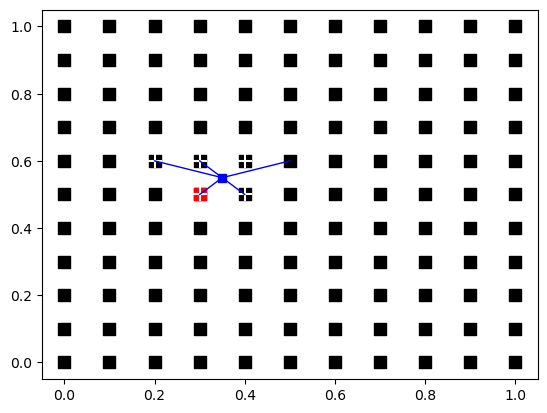

In [210]:
# ----------------------------------------------------------------
# Example usage
# ----------------------------------------------------------------
# Generate grid of 2D points
x = np.linspace(0,1,11)
y = np.linspace(0,1,11)
X,Y = np.meshgrid(x,y)
points = np.vstack([X.flatten(), Y.flatten()]).T
for p in points: plt.scatter(p[0],p[1],marker='s',s=70,color='black')
    
# Build KD-tree
tree = KDTree(points)

# # Query
query = (0.35, 0.55)
plt.scatter(query[0],query[1],marker = 's', s=40, color='blue')

nearest_point, dist = tree.nearest(query)
plt.scatter(nearest_point[0],nearest_point[1],marker = 's', s=70, color='red')

N_points,N_dists = tree.N_nearest(query, 5)
for p in N_points: plt.scatter(p[0],p[1],marker = '+', s=100, color='white')

R_points,R_dists = tree.radius_search(query, 0.4)
for p in R_points:
    plt.plot([p[0],query[0]],[p[1],query[1]],lw=1,color='blue')


### Example usage - Random grid of points in 2D

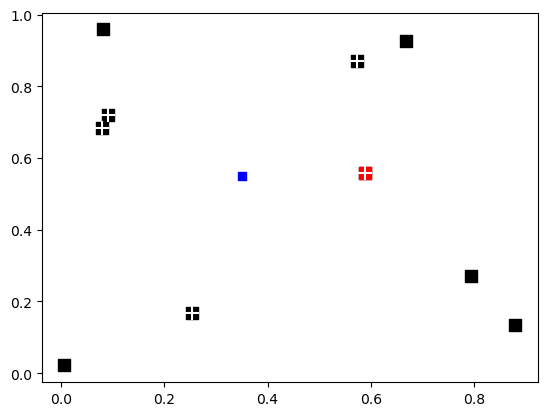

In [208]:
# ----------------------------------------------------------------
# Example usage
# ----------------------------------------------------------------
# Generate random 2D points
random.seed(0)
points = np.random.random((10,2))
for p in points: plt.scatter(p[0],p[1],marker='s',s=70,color='black')
    
# Build KD-tree
tree = KDTree(points)

# # Query
query = (0.35, 0.55)
plt.scatter(query[0],query[1],marker = 's', s=40, color='blue')

nearest_point, dist = tree.nearest(query)
plt.scatter(nearest_point[0],nearest_point[1],marker = 's', s=70, color='red')

N_points,N_dists = tree.N_nearest(query, 5)
for p in N_points: plt.scatter(p[0],p[1],marker = '+', s=100, color='white')

R_points,R_dists = tree.radius_search(query, 0.4)
for p in R_points:
    plt.plot([p[0],query[0]],[p[1],query[1]],lw=1,color='blue')
